In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import sys; sys.path.append('../src')

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from model.layers import NestedDropout
from model.cmpnts import MLP, SNMLP
from model.layers import SNLinearCombo
from toy_experiment import DynamicPruningAE, generate_configs
from torch.linalg import svd
from torch.utils.data import DataLoader

# 2D
## 1D Manifold

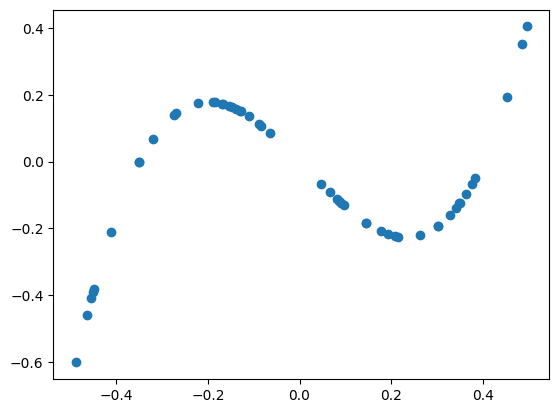

In [133]:
X, _ = torch.sort(torch.rand(50))
X = X - 0.5
# Y = X + 5 * X ** 3 
Y = 10 * (X-0.4) * X * (X+0.35)

plt.scatter(X.numpy(), Y.numpy())
plt.show()

In [134]:
configs = generate_configs(2, [32]*4, 'prune')
configs['beta'] = 0.9
configs['z_t'] = 3e-3
configs['r_t'] = 3e-6
ae = DynamicPruningAE(configs, MLP, SNMLP, torch.optim.Adam, [1., 1e-4])

data = torch.stack([X, Y], dim=-1)
dataloader = DataLoader(data, batch_size=50, shuffle=True)

ae.fit(dataloader, 5000)

Training prune: 100%|██████████████████████████████| 5000/5000 [00:43<00:00, 116.13it/s, rec=2.8e-5, spar=0.99]   


In [135]:
ae._zstd_, ae._p

(tensor([5.6052e-45, 9.7224e-01]), tensor([ True, False]))

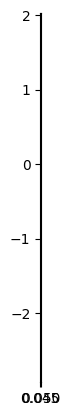

In [136]:
ae.eval()

z = ae.encode(data)
plt.scatter(z[:,0].detach().numpy(), z[:,1].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

In [137]:
z.max(0)[0] - z.min(0)[0]

tensor([0.0000, 4.5163], grad_fn=<SubBackward0>)

In [138]:
z.T.cov()

tensor([[1.4161e-17, 1.5407e-16],
        [1.5407e-16, 9.7369e-01]], grad_fn=<SqueezeBackward0>)

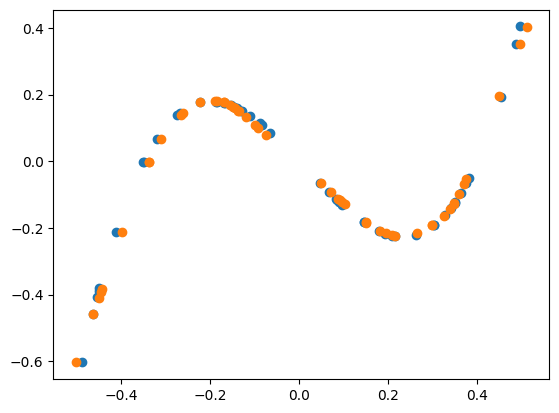

In [139]:
rec = ae.decode(z).detach().numpy()
plt.scatter(X.numpy(), Y.numpy())
plt.scatter(rec[:, 0], rec[:, 1])

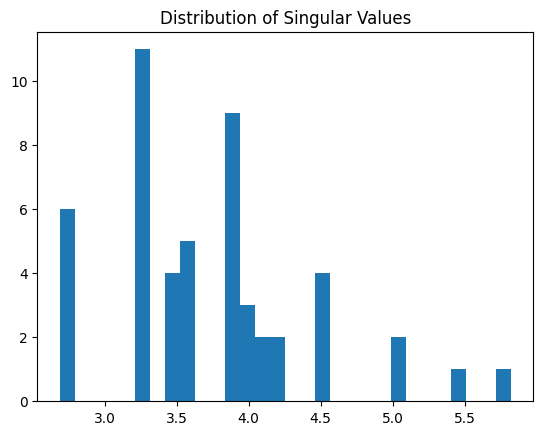

In [91]:
def f(x):
    return ae.encode(x).sum(0)

jcb = torch.autograd.functional.jacobian(f, data).transpose(1,0)
eig_list = torch.stack([svd(j)[1][0] for j in jcb])
plt.hist(eig_list.numpy(), bins=30)
plt.title('Distribution of Singular Values')
plt.show()

In [74]:
svd(jcb[0])

torch.return_types.linalg_svd(
U=tensor([[1.0000, 0.0000],
        [0.0000, 1.0000]]),
S=tensor([5.2604, 0.0000]),
Vh=tensor([[-0.9610, -0.2766],
        [-0.2766,  0.9610]]))

In [73]:
jcb[0]

tensor([[-5.0551, -1.4553],
        [ 0.0000,  0.0000]])

# 3D
## 1D

/tmp/ipykernel_2964324/3232837478.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


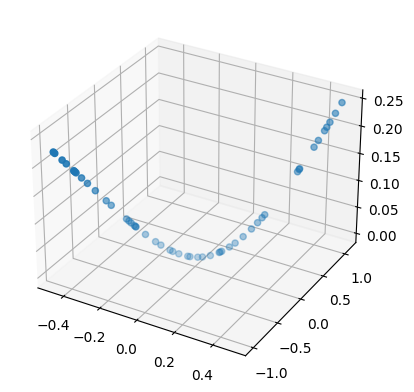

In [93]:
X, _ = torch.sort(torch.rand(50))
X = X - 0.5
Y = X + 5 * X ** 3
Z = X ** 2
data = torch.stack([X, Y, Z], dim=-1)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X.numpy(), Y.numpy(), Z.numpy())
fig.show()

In [94]:
configs = generate_configs(3, [32]*4, 'prune')
configs['beta'] = 0.9
configs['z_t'] = 3e-3
configs['r_t'] = 3e-6
ae = DynamicPruningAE(configs, MLP, SNMLP, torch.optim.Adam, [1., 1e-4])

dataloader = DataLoader(data, batch_size=50, shuffle=True)
ae.fit(dataloader, 5000)

Training prune: 100%|██████████████████████████████| 5000/5000 [00:43<00:00, 115.69it/s, rec=6.66e-7, spar=0.925] 


In [96]:
ae._zstd_, ae._p

(tensor([5.6052e-45, 5.6052e-45, 9.2698e-01]), tensor([ True,  True, False]))

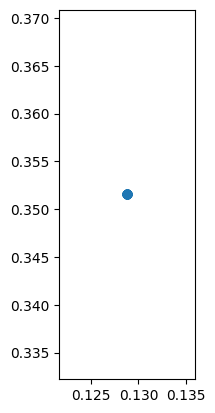

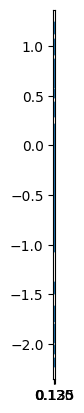

In [97]:
ae.eval()

z = ae.encode(data)
plt.scatter(z[:,0].detach().numpy(), z[:,1].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

plt.scatter(z[:,0].detach().numpy(), z[:,2].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

In [98]:
z.T.cov()

tensor([[0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.8556]], grad_fn=<SqueezeBackward0>)

/tmp/ipykernel_2964324/1616459218.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


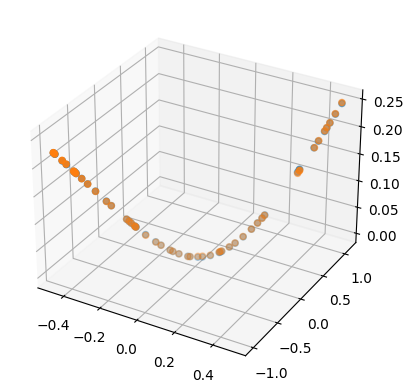

In [99]:
rec = ae.decode(z).detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X.numpy(), Y.numpy(), Z.numpy())
ax.scatter(rec[:, 0], rec[:, 1], rec[:, 2])
fig.show()

## 2D

/tmp/ipykernel_2964324/57433251.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


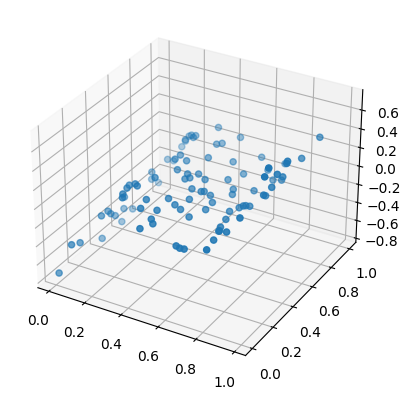

In [109]:
XY = torch.rand(100, 2)
X = XY[:, 0] - 0.5
Z = 10 * (X-0.3) * X * (X+0.3) 
data = torch.stack([XY[:,0], XY[:,1], Z], dim=-1)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(XY[:,0].numpy(), XY[:,1].numpy(), Z.numpy())
fig.show()

In [110]:
configs = generate_configs(3, [32]*4, 'prune')
configs['beta'] = 0.9
configs['z_t'] = 3e-3
configs['r_t'] = 1e-5
ae = DynamicPruningAE(configs, MLP, SNMLP, torch.optim.Adam, [1., 1e-4])

dataloader = DataLoader(data, batch_size=100, shuffle=True)
ae.fit(dataloader, 5000)

Training prune: 100%|██████████████████████████████| 5000/5000 [00:44<00:00, 113.49it/s, rec=3.04e-6, spar=1.06] 


In [111]:
ae._zstd_, ae._p

(tensor([6.9999e-01, 5.6052e-45, 1.6223e+00]), tensor([False,  True, False]))

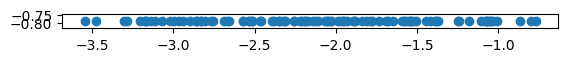

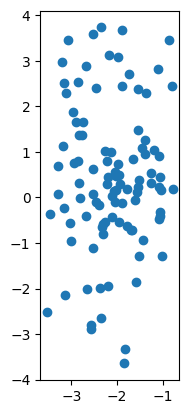

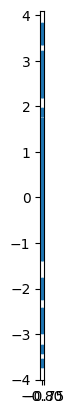

In [112]:
ae.eval()

z = ae.encode(data)

plt.scatter(z[:,0].detach().numpy(), z[:,1].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

plt.scatter(z[:,0].detach().numpy(), z[:,2].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

plt.scatter(z[:,1].detach().numpy(), z[:,2].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

/tmp/ipykernel_2964324/3938893466.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


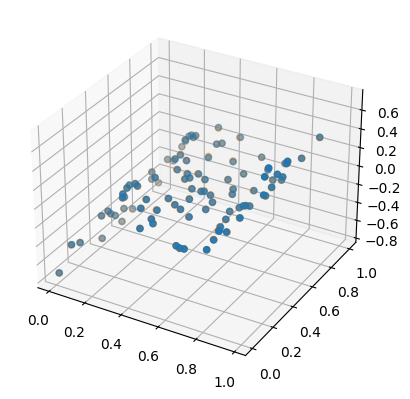

In [113]:
rec = ae.decode(z).detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(XY[:,0].numpy(), XY[:,1].numpy(), Z.numpy())
ax.scatter(rec[:, 0], rec[:, 1], rec[:, 2])
fig.show()

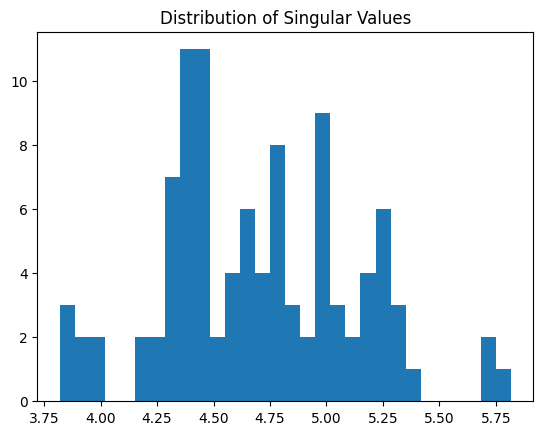

In [118]:
def f(x):
    return ae.encode(x).sum(0)

jcb = torch.autograd.functional.jacobian(f, data).transpose(1,0)
eig_list = torch.stack([svd(j)[1][0] for j in jcb])
plt.hist(eig_list.numpy(), bins=30)
plt.title('Distribution of Singular Values')
plt.show()

## Noise 2D

/tmp/ipykernel_2964324/493637931.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


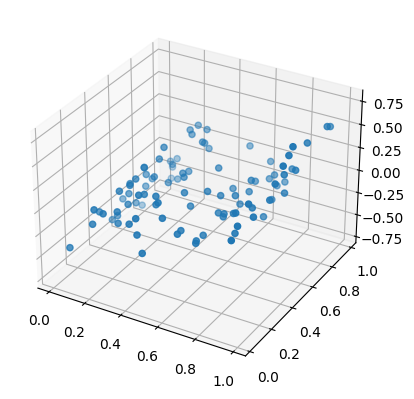

In [140]:
XY = torch.rand(100, 2)
X = XY[:, 0] - 0.5
Z = 10 * (X-0.3) * X * (X+0.3) + torch.randn(len(X))/10
data = torch.stack([XY[:,0], XY[:,1], Z], dim=-1)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(XY[:,0].numpy(), XY[:,1].numpy(), Z.numpy())
fig.show()

In [144]:
configs = generate_configs(3, [32]*4, 'prune')
configs['beta'] = 0.9
configs['z_t'] = 5e-3
configs['r_t'] = 1e-3
ae = DynamicPruningAE(configs, MLP, SNMLP, torch.optim.Adam, [1., 5e-4])

dataloader = DataLoader(data, batch_size=100, shuffle=True)
ae.fit(dataloader, 5000)

Training prune: 100%|██████████████████████████████| 5000/5000 [00:44<00:00, 112.79it/s, rec=0.000771, spar=1.15] 


In [145]:
ae._zstd_, ae._p

(tensor([5.6052e-45, 1.8610e+00, 7.0106e-01]), tensor([ True, False, False]))

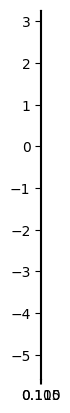

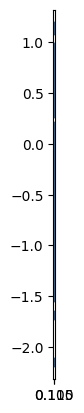

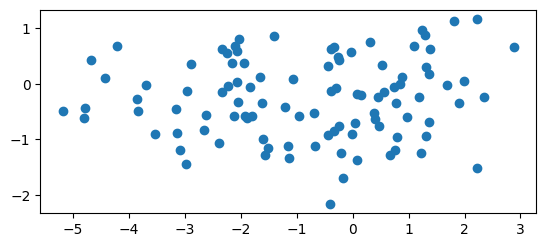

In [146]:
ae.eval()

z = ae.encode(data)

plt.scatter(z[:,0].detach().numpy(), z[:,1].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

plt.scatter(z[:,0].detach().numpy(), z[:,2].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

plt.scatter(z[:,1].detach().numpy(), z[:,2].detach().numpy())
plt.gca().set_aspect('equal')
plt.show()

/tmp/ipykernel_2964324/3938893466.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


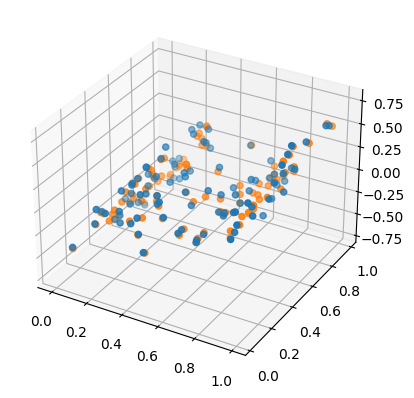

In [147]:
rec = ae.decode(z).detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(XY[:,0].numpy(), XY[:,1].numpy(), Z.numpy())
ax.scatter(rec[:, 0], rec[:, 1], rec[:, 2])
fig.show()

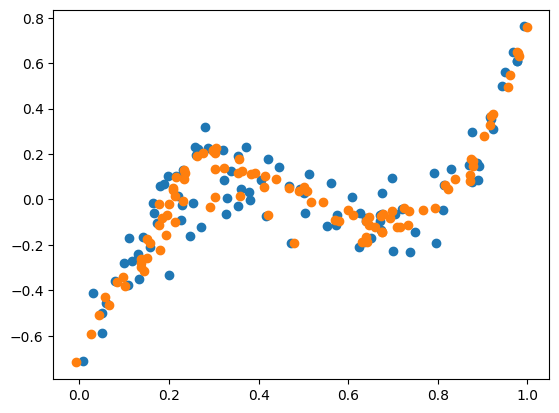

In [148]:
plt.scatter(XY[:,0].numpy(), Z.numpy())
plt.scatter(rec[:, 0], rec[:, 2])
plt.show()